# SUMMARY

## Utilities

Configuración de carpetas para poder usar archivos del proyecto de FastAPI:

In [1]:
import sys

sys.path.append('../..')

Utilidades de requests:

In [2]:
import requests
import pandas as pd

def post(url: str):
    payload={}
    headers = {}
    response = requests.request("POST", url, headers=headers, data=payload)
    return response.json()

Servicios del proyecto de FastAPI:

In [3]:
from app.services.dataset_service import DatasetService

dataset_service = DatasetService()

Curvas de aprendizaje con números de ejemplos:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(20, 4))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt

In [5]:
from app.services.custom_analysis_service import classifiers, CustomAnalysisService


def learning_curves_examples(
    file_path: str,
    classifier_name: str,
    dataset_name: str
):
    cas = CustomAnalysisService()

    df = cas.prepare_dataset(
        file_path=file_path,
        target_column='sentiment',
        text_column='answer'
    )

    x_values = df.drop(['sentiment', 'answer'], axis=1)
    y_values = df['sentiment']
    cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

    estimator = classifiers[classifier_name]

    plot_learning_curve(
        estimator=estimator,
        title=f'Curvas de aprendizaje en dataset {dataset_name} ({classifier_name} - examples)',
        X=x_values,
        y=y_values,
        ylim=(0.4, 1.01),
        cv=cv,
        n_jobs=4
    )


Curvas de aprendizaje con diferentes características:

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
%matplotlib inline


In [7]:
def rmse(a, b):
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    return np.sqrt(np.mean(np.square(a - b)))

def learning_curve01(model, x_train, x_test, y_train, y_test, features):
    training_errors= []
    testing_errors= []

    for i in range(1, len(features) + 1):
        model.fit(x_train[features[0:i]], y_train)
        y = model.predict(x_test[features[0:i]])
        training_errors.append(rmse(model.predict(x_train[features[0:i]]), y_train))
        testing_errors.append(rmse(model.predict(x_test[features[0:i]]), y_test))
    return [training_errors, testing_errors]
    

In [8]:
def plot_curve01(
    training_errors,
    test_errors,
    classifier_name: str,
    dataset_name: str
):
    plt.figure(figsize=(20, 4))

    plt.plot(
        training_errors,
        'o-',
        mfc="none",
        mec="b",
        ms=10,
        color='blue',
        label="Training"
    )

    plt.plot(
        test_errors,
        'x-',
        mfc="none",
        mec="g",
        ms=10,
        color='green',
        label="Test"
    )

    plt.legend()
    plt.xlabel("Polinomial Complexity(x)")
    plt.ylabel("RMSE (y)")
    plt.title(
        f'Curvas de aprendizaje en dataset {dataset_name} ({classifier_name} - features)')
    plt.show()


In [9]:
from sklearn.model_selection import train_test_split
from app.services.custom_analysis_service import classifiers, CustomAnalysisService


def learning_curves_features(
    file_path: str,
    classifier_name: str,
    dataset_name: str
):
    cas = CustomAnalysisService()

    df = cas.prepare_dataset(
        file_path=file_path,
        target_column='sentiment',
        text_column='answer'
    )

    x_values = df.drop(['sentiment', 'answer'], axis=1)
    y_values = df['sentiment']

    seed = 1234

    x_train, x_test, y_train, y_test = train_test_split(
        x_values,
        y_values,
        test_size=0.3,
        random_state=seed
    )

    features = x_values.columns.to_list()
    model = classifiers[classifier_name]
    model.fit(x_train, y_train)

    train_error, test_error = learning_curve01(
        model,
        x_train,
        x_test,
        y_train,
        y_test,
        features
    )

    plot_curve01(train_error, test_error, classifier_name, dataset_name)

## Analysis

In [10]:
metrics = [
    'accuracy',
    'sensitivity',
    'specificity',
    'auc',
    'kappa',
    'f1',
    'precision'
]

counts = ['tp', 'fp', 'tn', 'fn']

In [11]:
custom_evaluation_url = 'http://localhost:8000/analysis/custom_evaluation'
metrics_custom_url = 'http://localhost:8000/analysis/metrics_custom'
figsize = (20, 4)


def summary(file_path: str, dataset_name: str):
    url_evaluation = f'{custom_evaluation_url}?file_path={file_path}'
    file_evaluation = post(url_evaluation)['file_path']
    url_metrics = f'{metrics_custom_url}?file_path={file_evaluation}'
    file_metrics = post(url_metrics)['file_path']

    df_metrics = dataset_service.read_dataset(
        file_path=f'../../resources/metrics/{file_metrics}',
        encoding='utf-8',
        delimiter=','
    )

    df_metrics[['algorithm'] + metrics].plot.bar(
        x='algorithm',
        figsize=figsize,
        title=f'Métricas en dataset {dataset_name}'
    )

    df_metrics[['algorithm'] + counts].plot.bar(
        x='algorithm',
        figsize=figsize,
        title=f'Conteos en dataset {dataset_name}'
    )

    for classifier_name in classifiers:
        learning_curves_examples(
            file_path=f'../../resources/cleaned/{file_path}',
            classifier_name=classifier_name,
            dataset_name=dataset_name
        )

        learning_curves_features(
            file_path=f'../../resources/cleaned/{file_path}',
            classifier_name=classifier_name,
            dataset_name=dataset_name
        )

    return (df_metrics)


## Dataset original

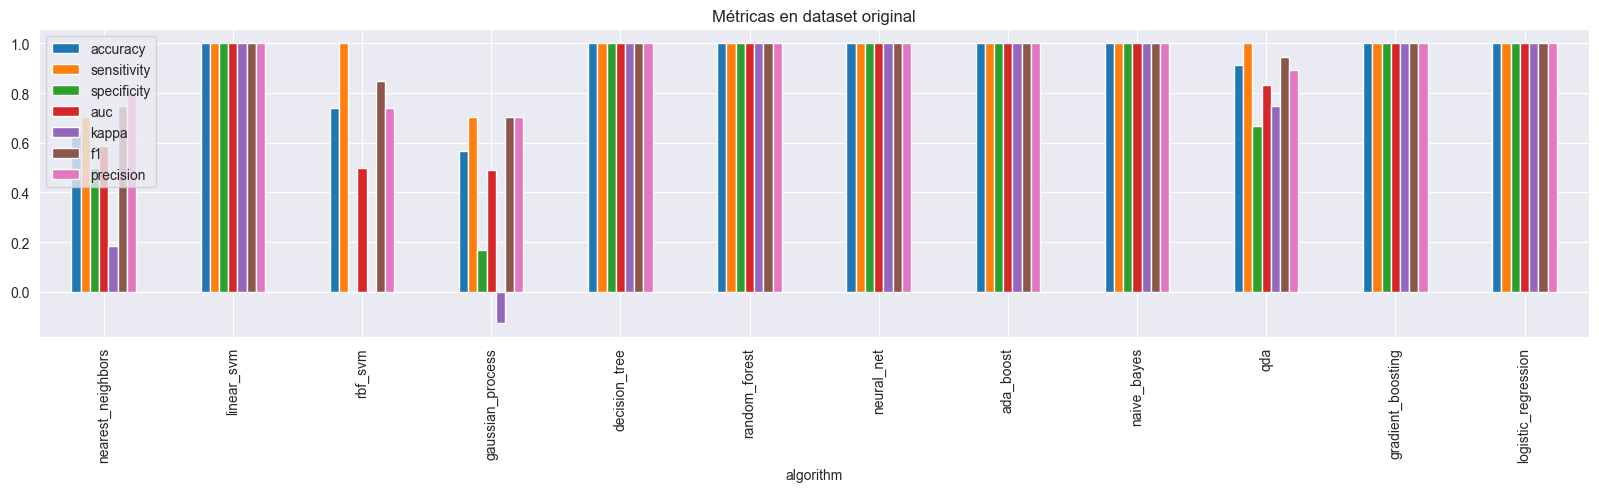

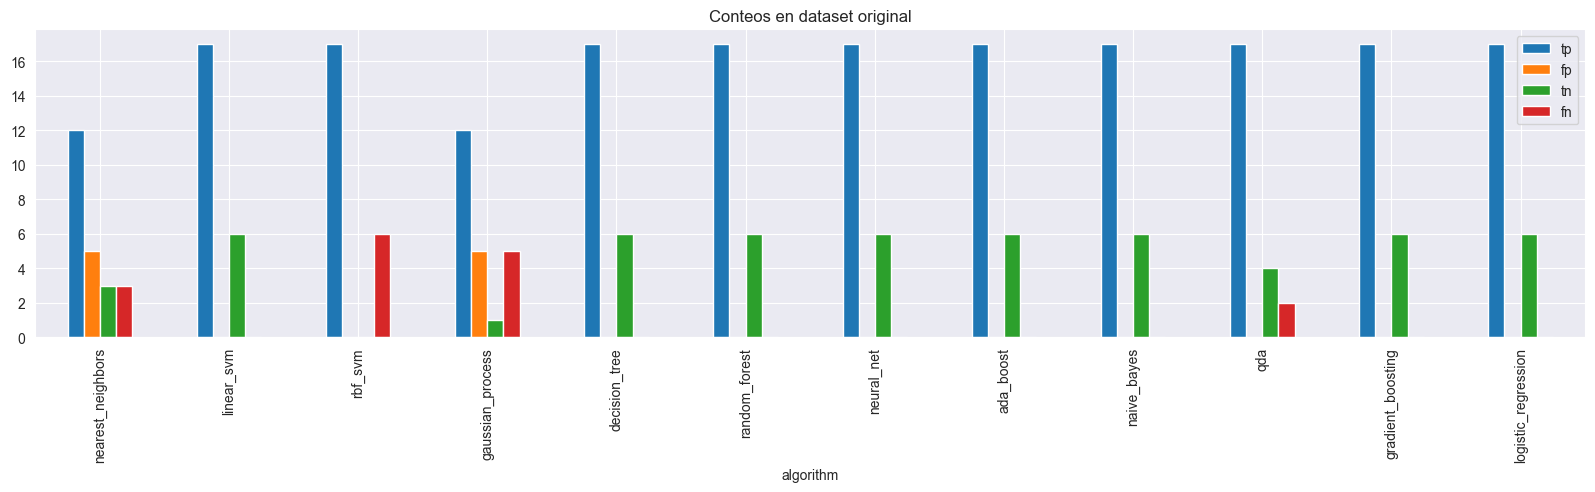

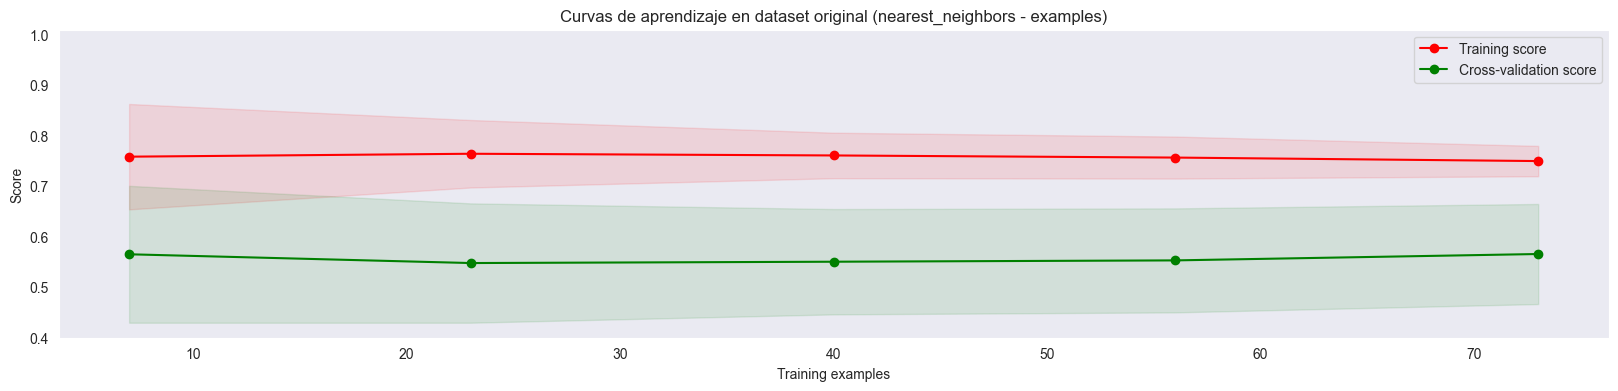

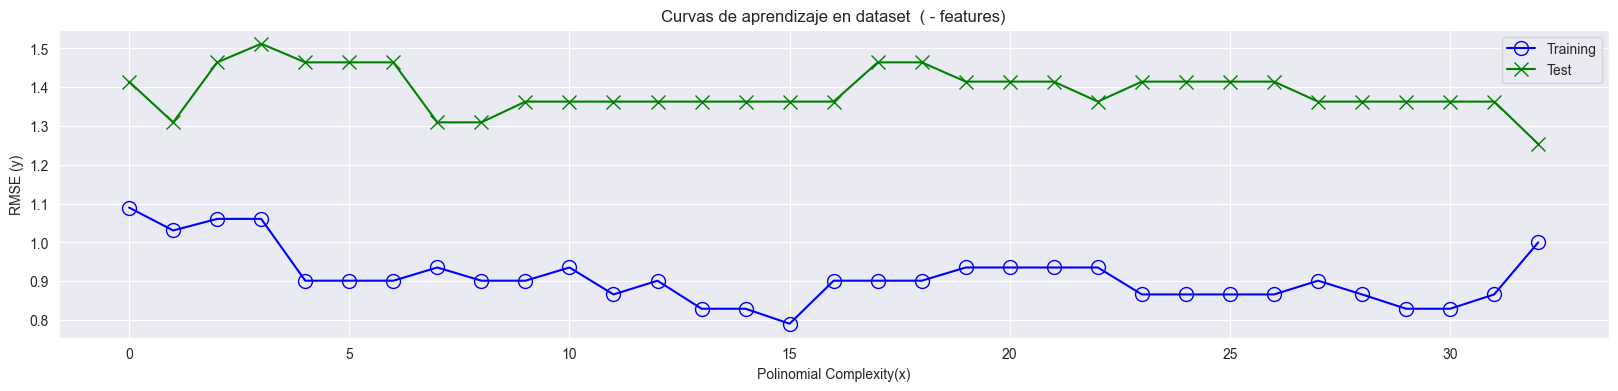

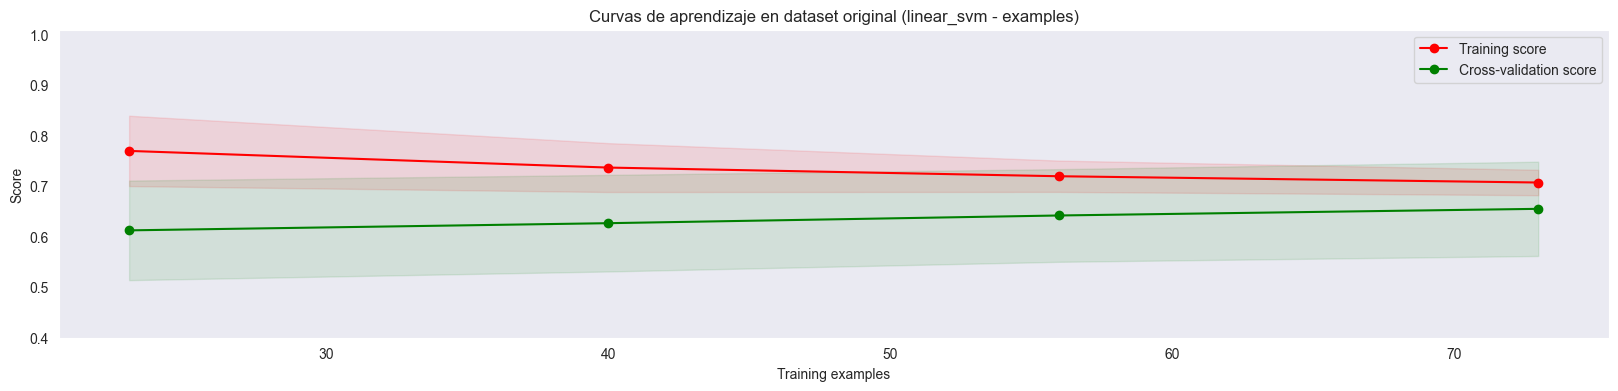

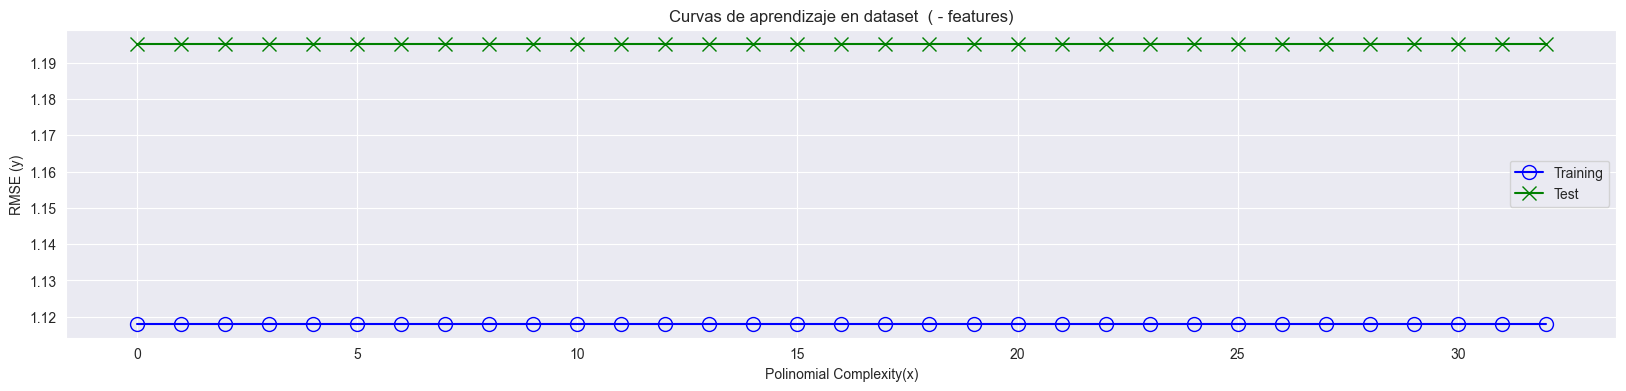

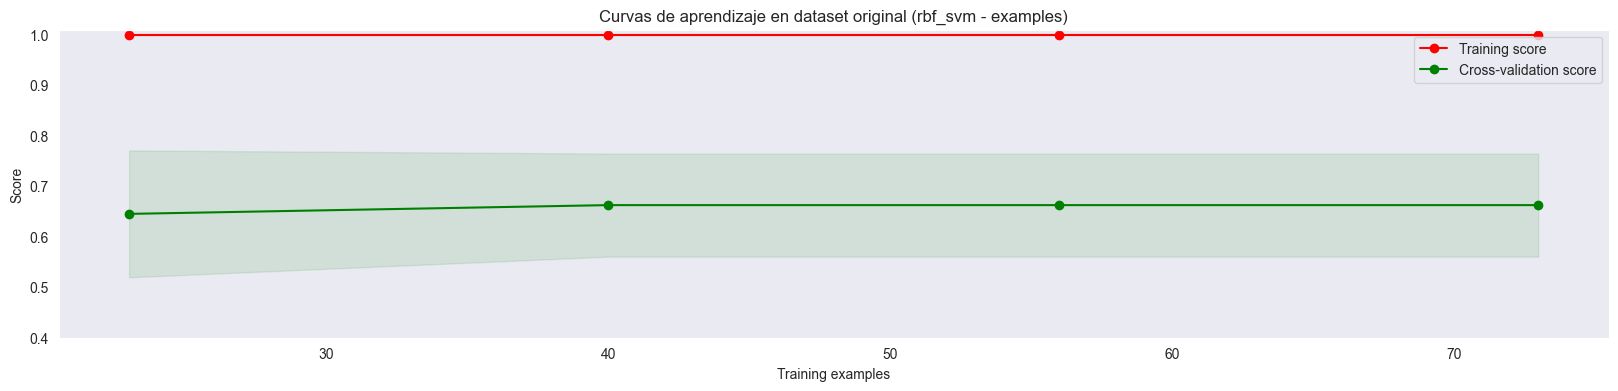

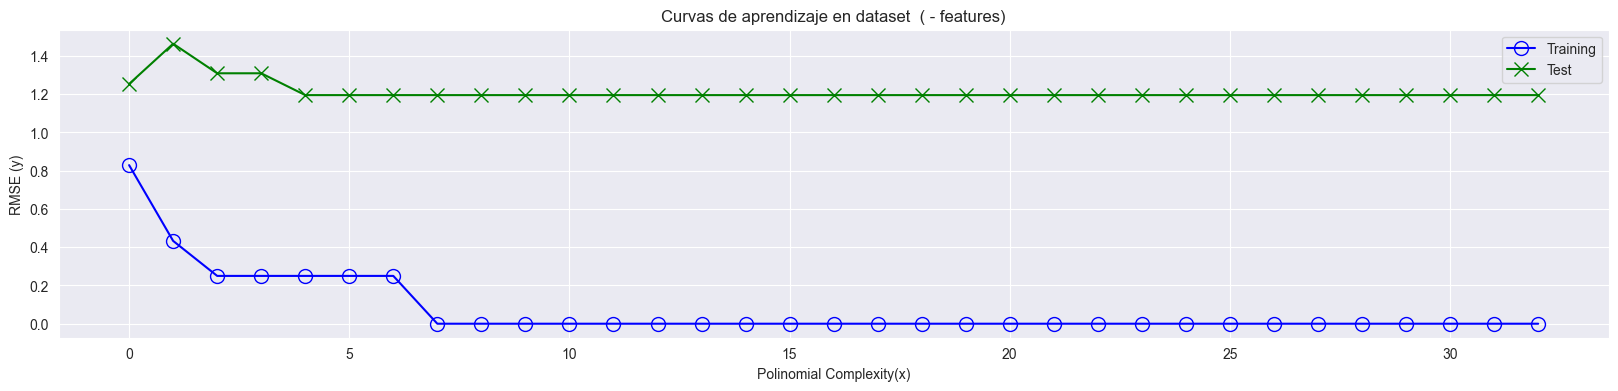

/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100

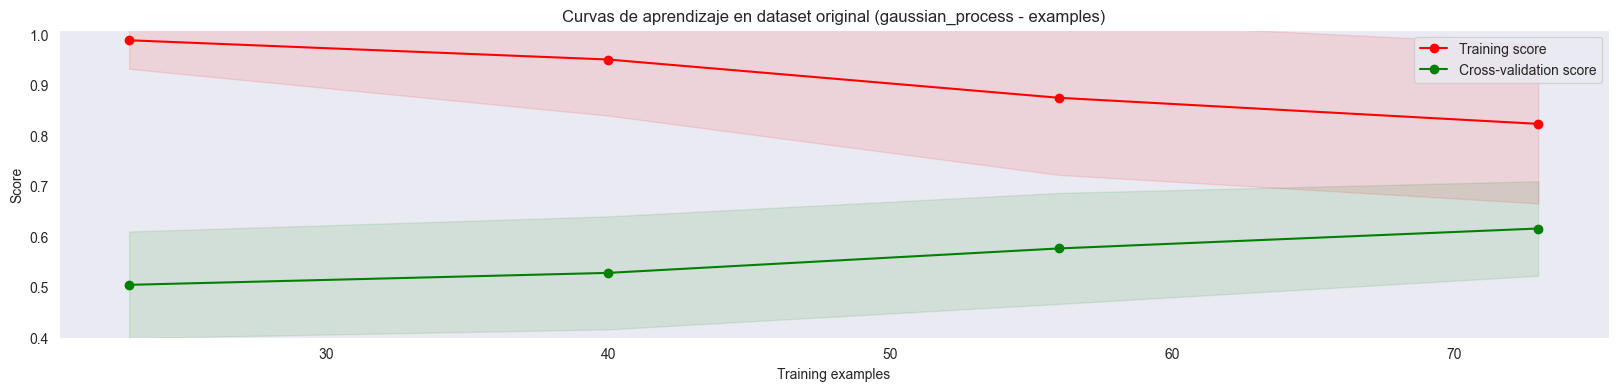

/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100

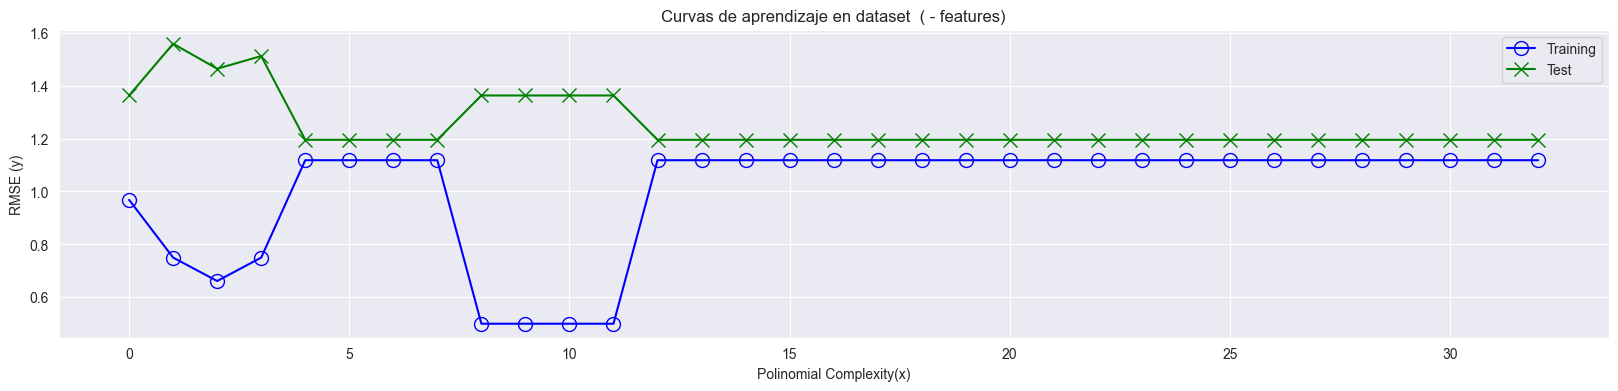

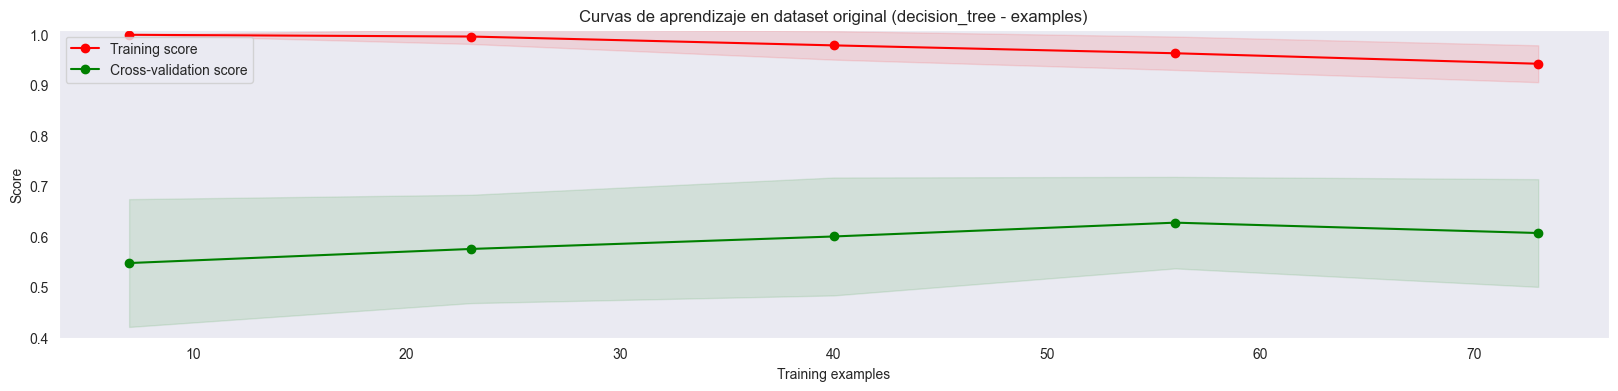

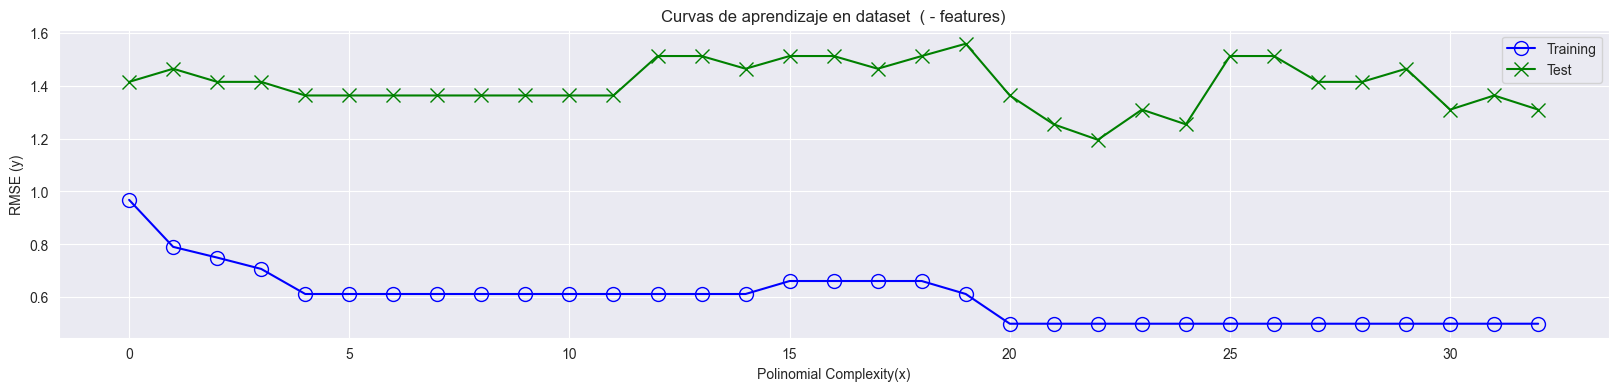

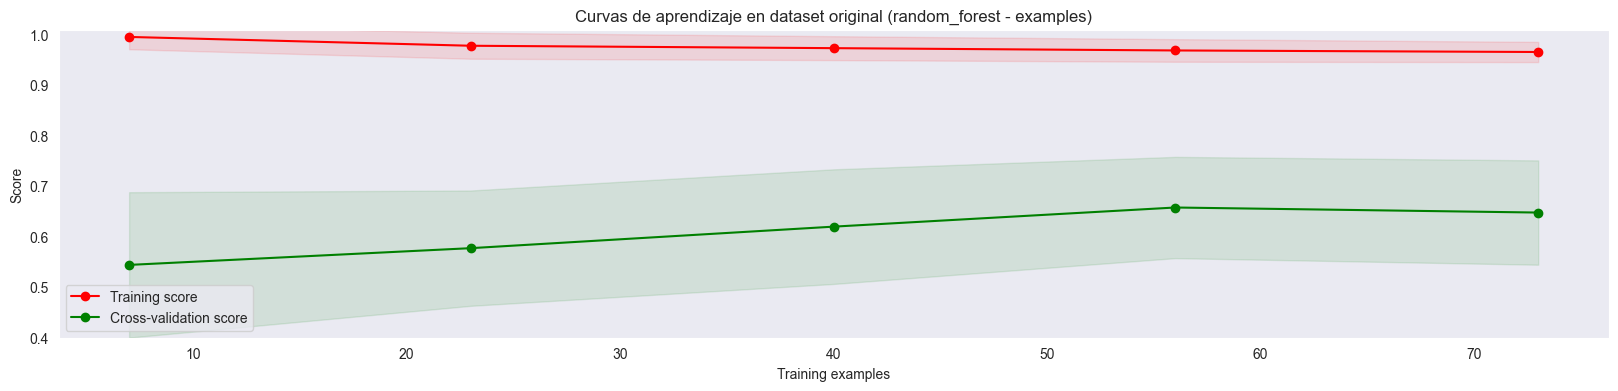

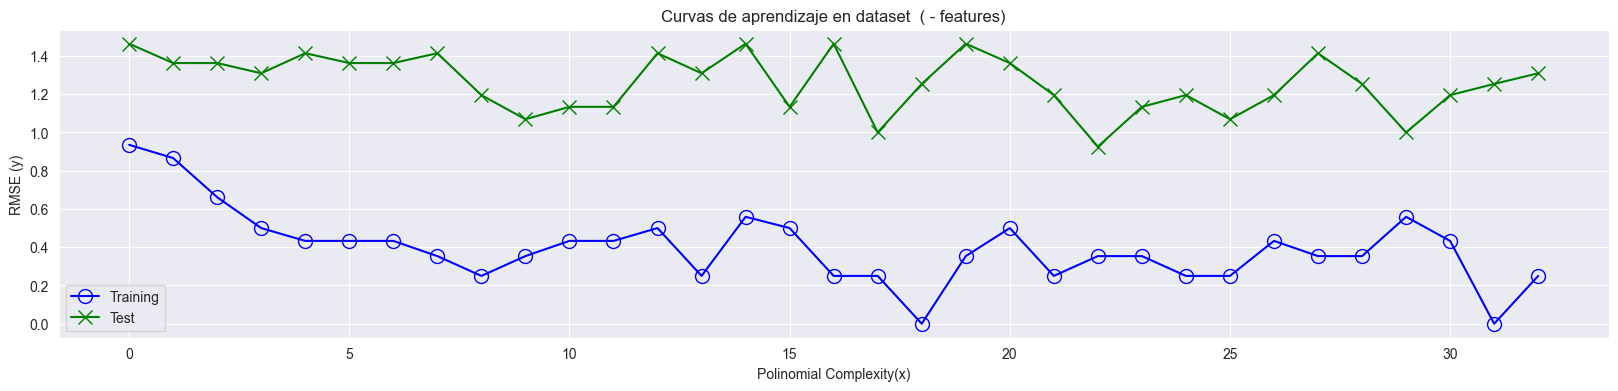

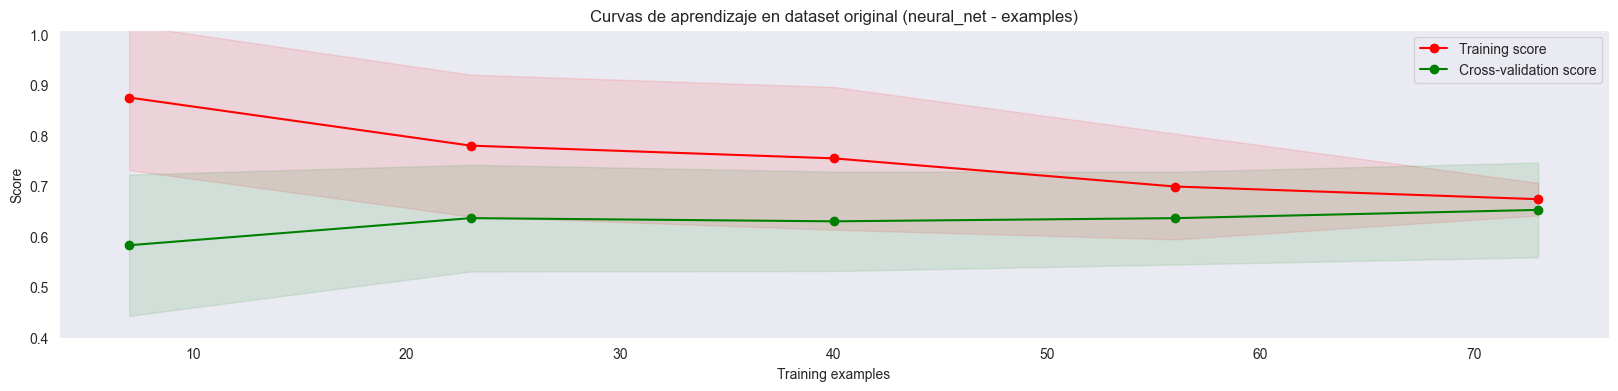

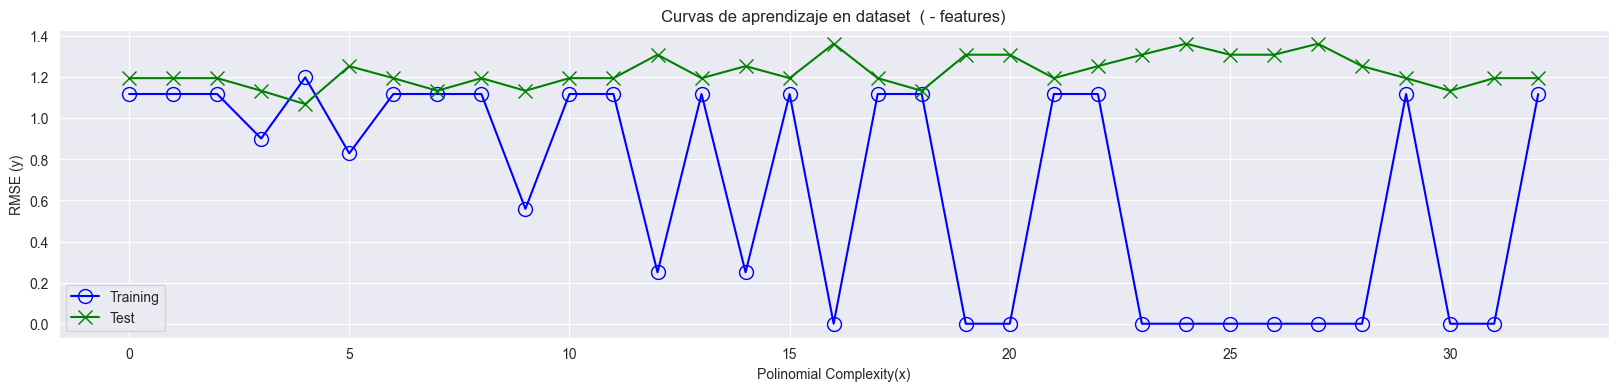

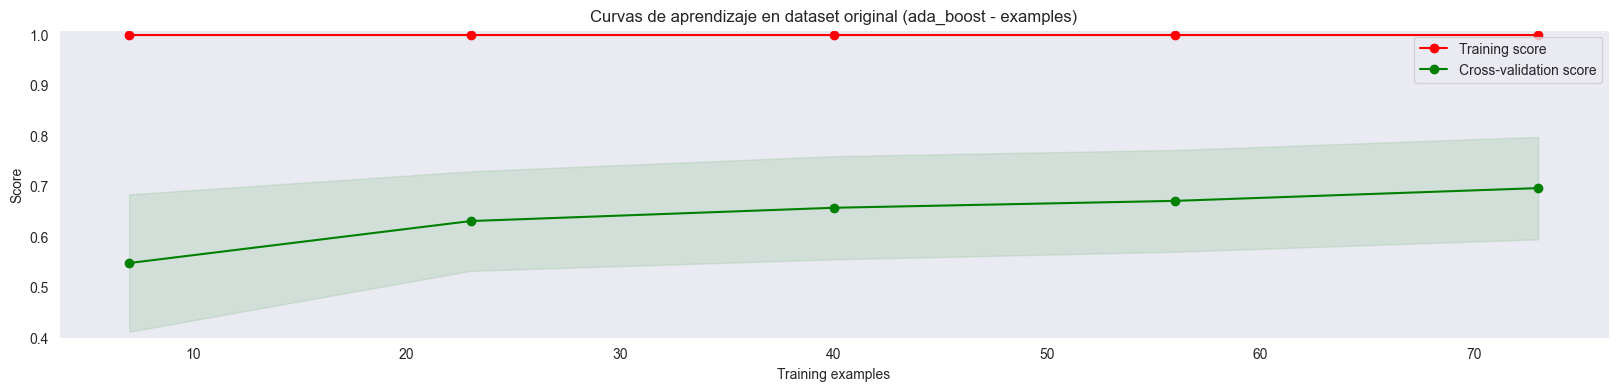

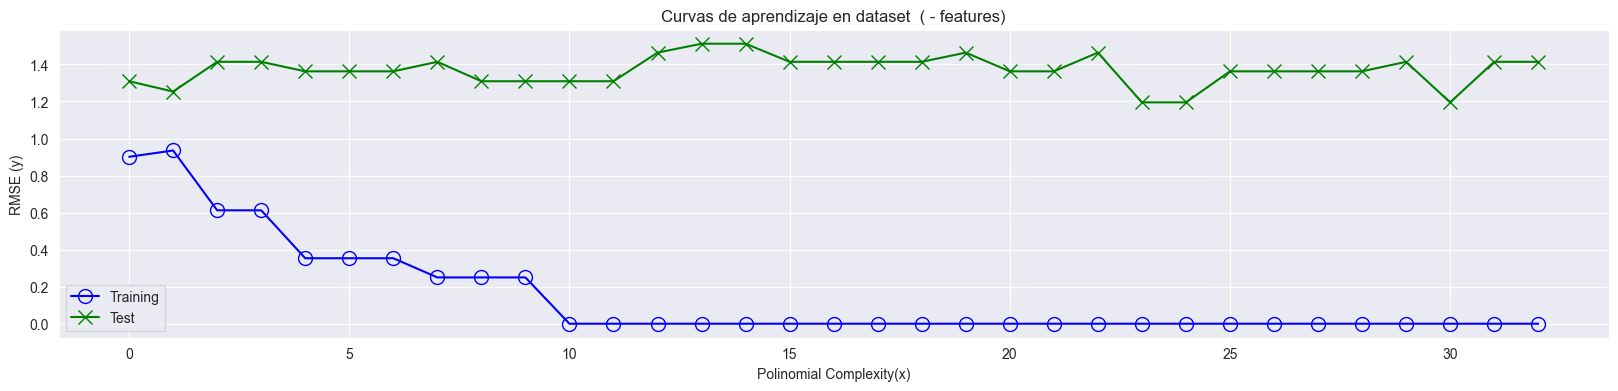

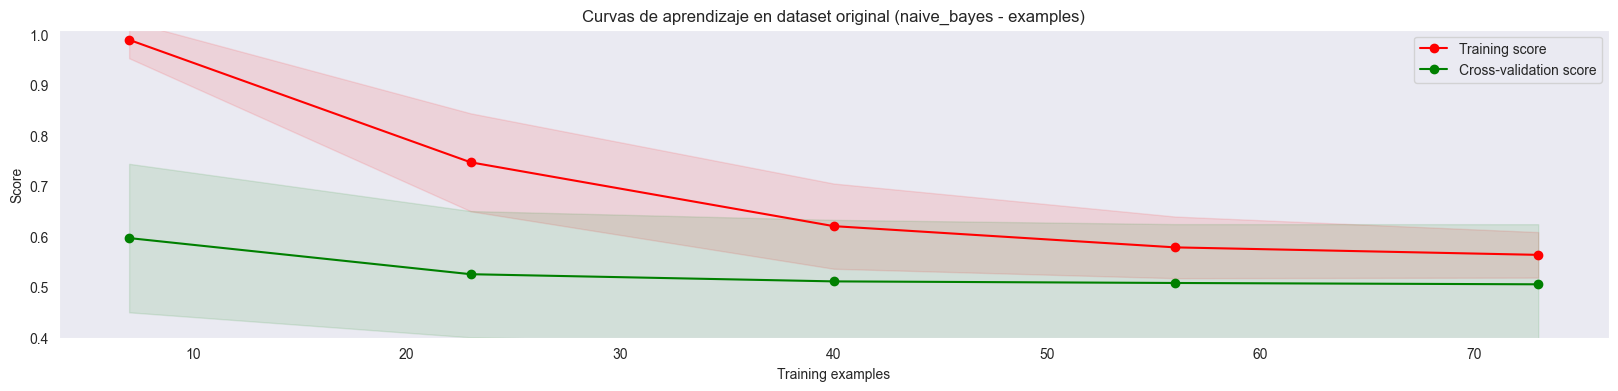

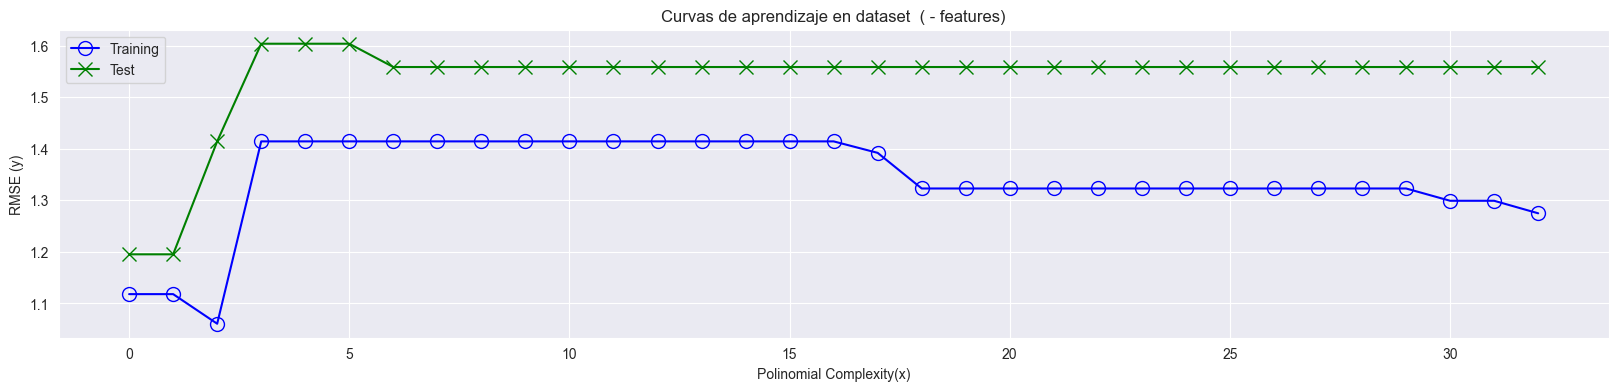

/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/discriminant_analysi

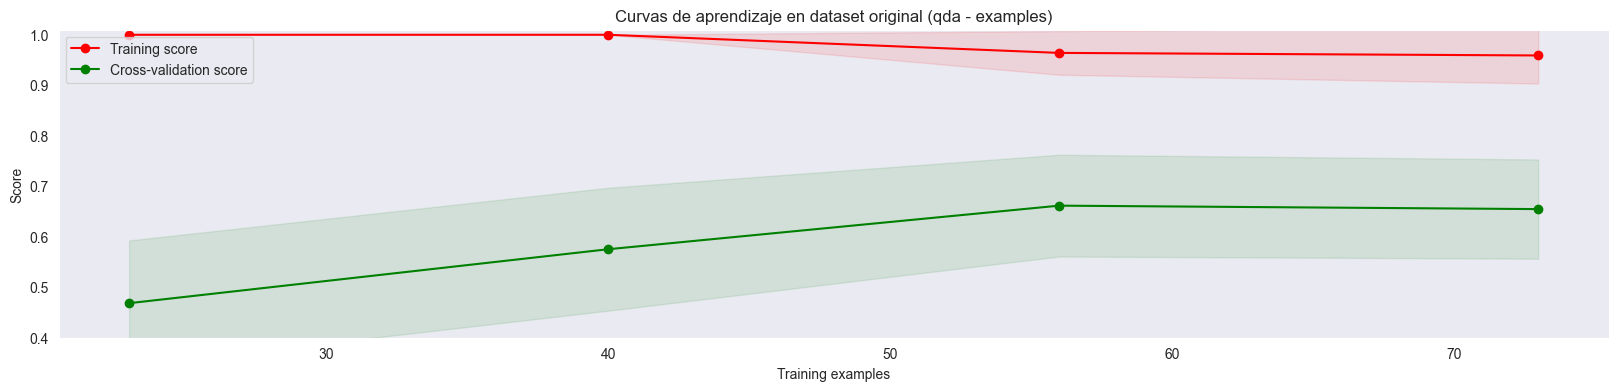

/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:951: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:951: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/

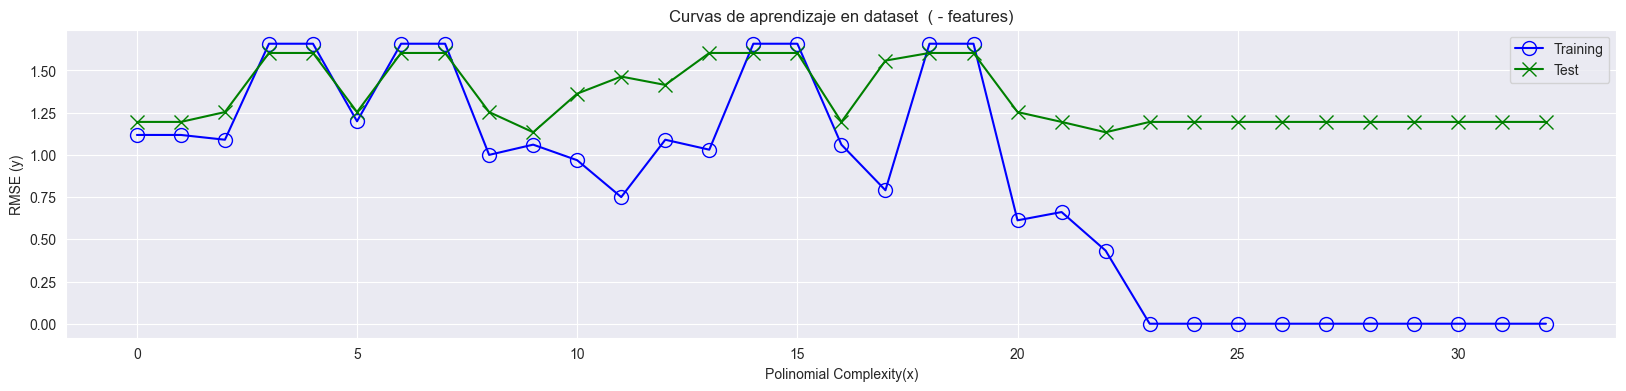

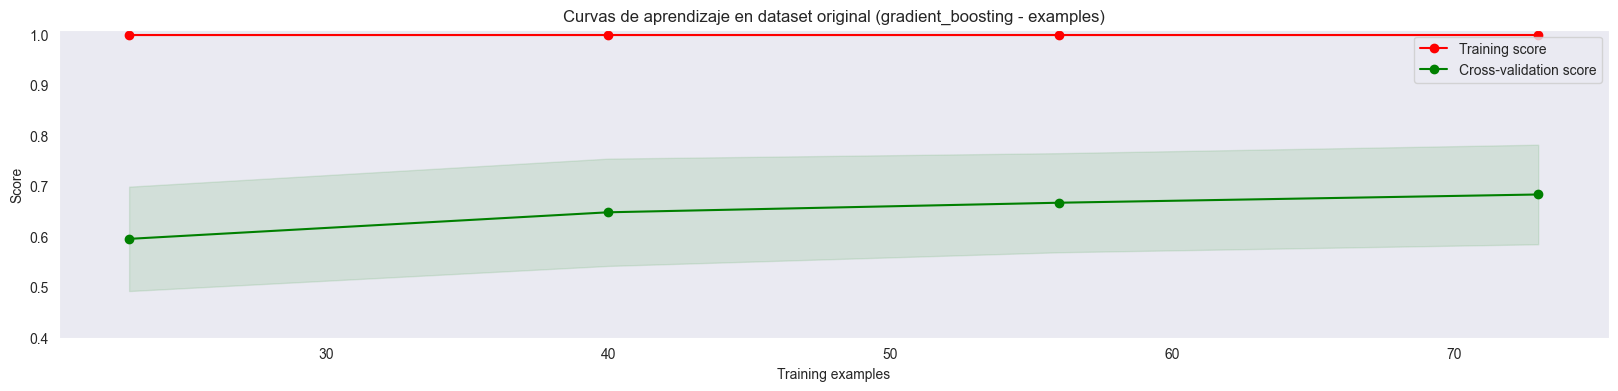

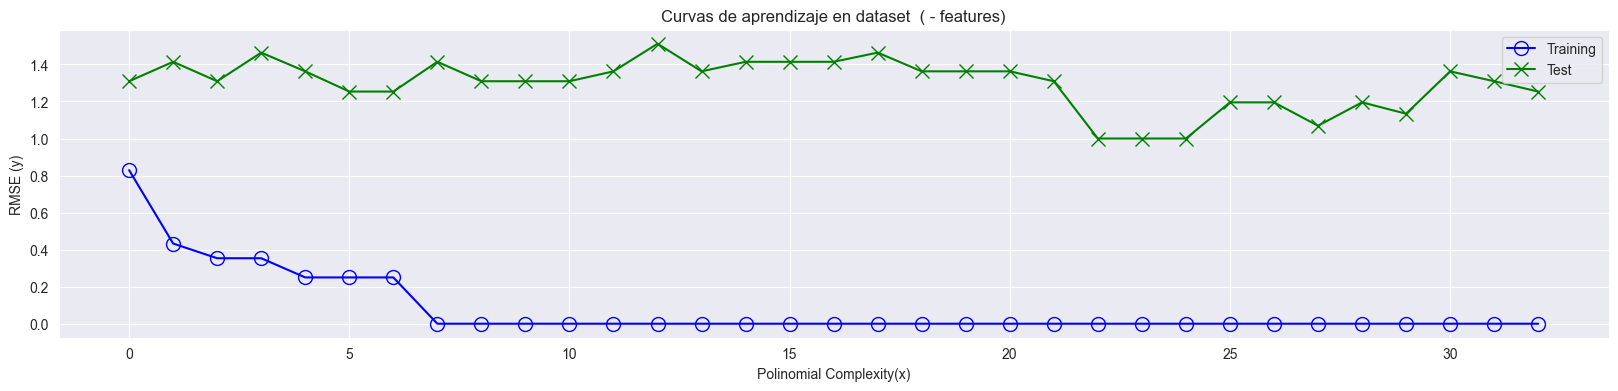

/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alter

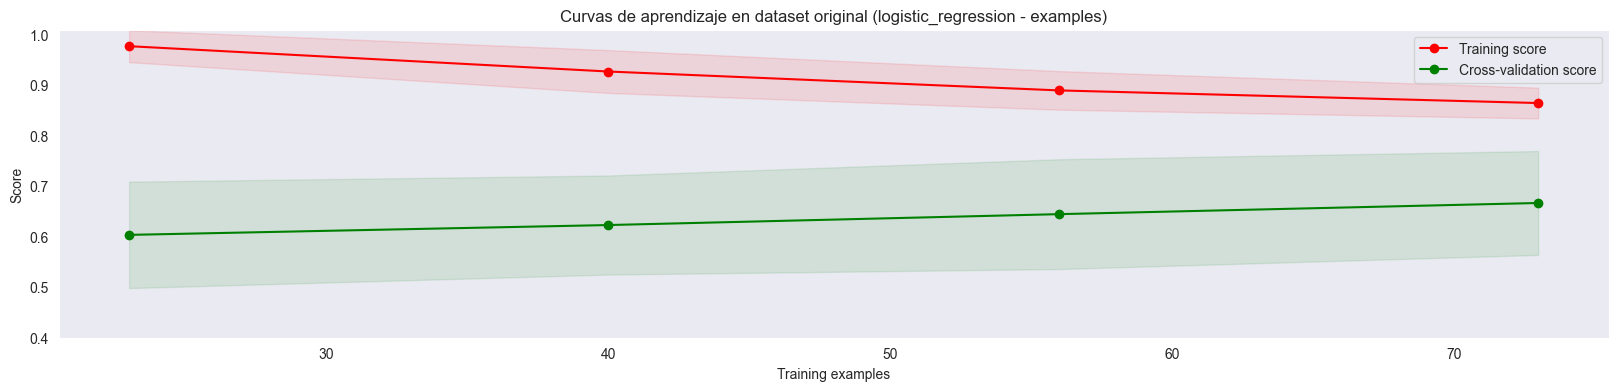

/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alter

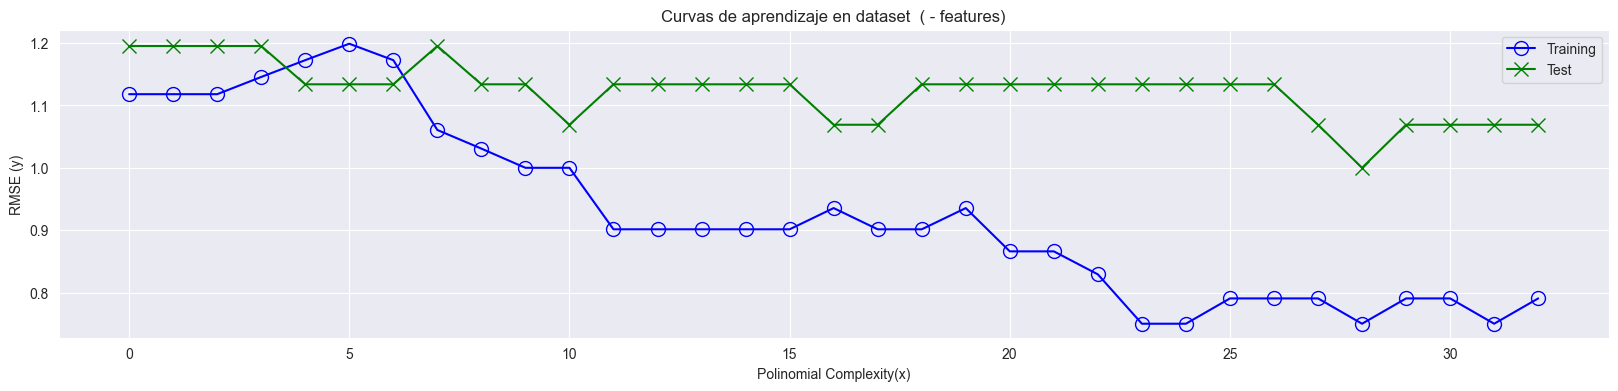

,algorithm,accuracy,sensitivity,specificity,kappa,f1,precision,tp,fp,tn,fn,auc
0,nearest_neighbors,0.652174,0.705882,0.500000,0.185841,0.750000,0.800000,12,5,3,3,0.588235
1,linear_svm,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17,0,6,0,1.000000
2,rbf_svm,0.739130,1.000000,0.000000,0.000000,0.850000,0.739130,17,0,0,6,0.500000
3,gaussian_process,0.565217,0.705882,0.166667,-0.127451,0.705882,0.705882,12,5,1,5,0.490196
4,decision_tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17,0,6,0,1.000000
5,random_forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17,0,6,0,1.000000
6,neural_net,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17,0,6,0,1.000000
7,ada_boost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17,0,6,0,1.000000
8,naive_bayes,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17,0,6,0,1.000000
9,qda,0.913043,1.000000,0.666667,0.747253,0.944444,0.894737,17,0,4,2,0.833333


In [12]:
summary(file_path='cle_respuestas_form_1671774115.csv', dataset_name='original')


## Dataset balanceado

## Dataset original normalizado

## Dataset balanceado normalizado